# 4. 모델 훈련

모델이 실제로 어떻게 작동하는지 이해하고 있으면 적절한 모델, 올바른 훈련 알고리즘, 적절한 하이퍼파라미터를 찾는데 도움이 됨.

이 장에서는 선형회귀, 다항회귀, 로지스틱회귀와 소프트맥스 회귀를 살펴봄으로써 신경망을 이해하고 구축하는데 도움이 되도록 할 것임.

## 4.1 선형회귀

선형회귀 모델은 정규방정식을 사용하거나 경사하강법을 사용하여 모델을 훈련시킴.

### 4.1.1 정규방정식

비용 함수를 최소화하는 θ값을 찾기 위한 해석적인 방법(수학 공식)을 정규방정식이라고 함.

In [1]:
import numpy as np
X = 2 * np.random.rand(100,1) # 0~1의 균등 분포에서 난수를 뽑아내어 (100,1) matrix 생성
y = 4 + 3 * X + np.random.randn(100,1) # 가우시안분포(표준정규분포)에서 난수를 뽑아내어 (100,1) matirx 생성.

#cf) np.random.randint 주어진 하이퍼파라미터에 따라 정수를 random하게 뽑아냄.

In [2]:
X_b = np.c_[np.ones((100,1)), X] #행렬 곱셈을 위해 x_0 = 1을 모든 샘플에 추가
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y) #정규방정식을 활용한 계산
theta_best

array([[4.49300323],
       [2.64430598]])

y = 4 + 3 * X + np.random.randn(100,1)식을 줄때 θ_0 = 4, θ_1 = 3을 기대한 것임.  
하지만 np.random.randn(100,1)과 같은 잡음 때문에 원래 함수의 파라미터를 정확하게 재현하지 못하는 것.

In [3]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.49300323],
       [9.78161518]])

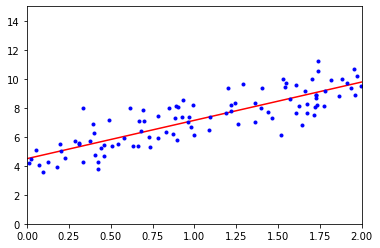

In [4]:
from matplotlib import pyplot as plt
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

### 4.1.2 scikit learn을 활용한 선형회귀 수행

In [5]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.49300323]), array([[2.64430598]]))

In [6]:
lin_reg.predict(X_new)

array([[4.49300323],
       [9.78161518]])

LinearRegression 클래스는 scipy.linalg.listq()함수를 기반으로 함. 이 함수를 직접 호출하는 것도 가능.

In [7]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.49300323],
       [2.64430598]])

위 함수는 유사역행렬(의사역행렬)을 활용하여 파라메타를 계산함. np.linalg.pinv()를 사용하여 유사역행렬을 직접 구할 수도 있음.  
유사 역행렬: A_+ = (A_T*A)^-1*A_T


In [8]:
np.linalg.pinv(X_b).dot(y)

array([[4.49300323],
       [2.64430598]])

유사역행렬 자체는 특잇값 분해(SVD, singular value decomposition)을 사용해 계산됨.  
정규방정식을 계산하는 것보다 이 방식이 훨씬 효율적이며 극단적인 경우도 처리할 수 있음.

## 4.2 경사하강법

경사 하강법은 최적의 해법을 찾는데 사용하는 일밬적인 최적화 알고리즘임.  
경사 하강법은 기본적으로 비용 함수를 최소화하기 위해 반복적으로 파라미터를 조정해 감.  
<br>
경사하강법은  
1.파라미터 벡터 θ에 대해 비용함수의 현재 gradient를 계산한 후,<br> 2. gradient가 감소하는 방향으로 진행하여, <br>3. θ=0이 되는 값(최솟값)을 찾는 방식으로 진행됨.  
<br>
경사 하강법에서 가장 중요한 파라미터는 스텝의 크기로 파라미터가 최솟값에 가까워 질수록 스텝크기가 점진적으로 줄어듦.  이 스텝의 크기를 결정하는 것은 학습률(learning rate) 하이퍼파라미터로 결정함.  
<br>
일반적으로 학습률이 너무 크면 최솟값을 지나쳐 발산하게 만들어 최솟값을 못 찾을 수 있음.  
또한 학습률이 너무 작을 경우에는 최솟값을 찾기 위해 반복을 많이 진행해야하므로 시간이 오래 걸림.  
적절한 학습률을 찾기 위해서는 그리드 탐색을 사용해야하지만 그리드 탐색에서 수렴하는데 너무 오래 걸리는 모델을 막기 위해 반복 횟수를 제한해야 함.  
<br>
적절한 반복 횟수를 찾기 위해서 반복 횟수를 아주 크게 지정하고 gradient vector가 아주 작아지면(벡터의 노름이 허용오차보다 작아지면) 경사 하강법이 최솟값에 도달한 것으로 보고 알고리즘을 중지하면 됨.
<br>
일반적으로 선형 회귀를 위한 MSE 비용 함수는 볼록함수여서 위 2가지 문제점 외에 크게 고려해야할 사항이 없지만 비용함수가 볼록함수가 아닐경우,  
1. 무작위 초기화 진행시 전역 최솟값이 아닌 지역 최솟값에 수렴할 수 있음.  
2. 평탄한 지역을 지날 시 전역 최솟값에 도달하지 못하고 시간만 오래 걸릴 수 있음.  


cf) 모델 훈련은 비용 함수를 최소화하는 모델 파라미터의 조합을 찾는 일이며 이를 모델의 파라미터 공간에서 찾는다고 함.  

cf) 경사하강법을 사용할 때는 정규방정식, SVD와는 달리 반드시 scikitlearn의 StandardScaler를 사용하여 모든 특성이 같은 스케일을 갖게 하여 수렴하는데 시간이 지나치게 오래 걸리지 않도록 해야함.  


### 4.2.1 배치 경사 하강법

배치 경사 하강법은 매 경사 하강법 스텝에서 전체 훈련 세트 X에 대해 그레디언트 벡터(비용함수의 편도함수를 모두 담고 있는 벡터)를 계산함.  
매 스텝에서 훈련 데이터 전체를 사용하기에 매우 큰 훈련 세트에서는 아주 느리다는 단점이 있으나 특성 수에 민감하지 않다는 장점도 있음.  
ex) 수십만 개의 특성에서 선형 회귀를 훈련시키기에는 경사 하강법이 정규방정식이나 SVD 분해보다 빠름. 
cf) 편도함수: 각 모델 파라미터 θj에 대해 θj가 변경될 때 비용함수가 얼마나 바뀌는지를(비용함수의 gradient를) 계산하는 함수.

In [9]:
eta = 0.1 #학습률
n_iterations = 1000 #배치 경사 하강법은 SGD나 미니 배치 경사하강법에 비해 반복회수가 많음.
m = 100

theta = np.random.randn(2,1) #무작위 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [10]:
theta #정규방정식으로 찾은 것과 정확히 같은 값을 찾아냈음.

array([[4.49300323],
       [2.64430598]])

### 4.2.2 확률적 경사 하강법(SGD)

확률적 경사 하강법은 매 스텝에서 한개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 gradient를 계산함.  
<br>
매 반복에서 다뤄야할 데이터가 적기 때문에 배치 경사 하강법 보다 빠르고 메모리 효율적이기 때문에 큰 훈련세트도 훈련시킬 수 있음.  
또한 확률적 경사 하강법은 위아래로 요동치며 평균적으로 감소하기에 지역 최솟값을 건너뛰고 전역 최솟값을 찾을 가능성도 더 높음.  
하지만 무작위로 샘플을 선택하므로 배치 경사 하강법보다 훨씬 불안정하며 위아래로 요동치는게 지속되다가 최솟값에 안착하지 못할 수도 있음.

<br>
따라서 학습률을 점진적으로 감소시켜 확률적 경사 하강법의 장점은 살리면서도 전역 최솟값에 도달할 수 있도록 해야함.<br>
매 반복에서 학습률을 결정하는 함수를 학습 스케줄이라고 함.
<br>
학습률이 너무 빨리 감소하면 지역 최솟값에 갇히거나 최솟값까지 가지 못하고 중간에 멈출 수도 있음.  
<br>
학습률이 너무 천천히 감소하면 최솟값 주변을 오래 맴돌거나 훈련을 너무 일찍 중지하여 지역 최솟값에 머무를 수 있음.  
<br>

In [11]:
n_epochs = 50 #각 반복을 epoch라고 함. 배치 경사 하강법보다 적게 반복하고 좋은 값에 도달 가능.
t0, t1 = 5, 50 #학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

In [12]:
theta

array([[4.49311521],
       [2.68061326]])

샘플을 무작위로 선택하기 때문에 특정 샘플만 선택될 수도 있음.  
알고리즘이 에포크마다 모든 샘플을 사용하게 하려면 훈련하는 동안 샘플을 섞어야 함. (IID를 만족시켜야지 평균적으로 파라미터가 전역 최적점을 향해 진행한다고 보장할 수 있음.)  

cf) scikitlearn에서 SGD 방식으로 선형 회귀를 사용하려면 SGDRegressor 클래스를 사용함.

In [13]:
#최대 1000번의 epoch동안 실행되고 한 에포크에서 0.001보다 적게 손실(tol=1e-3)이 줄어들 때까지 실행되는 예시
#학습률은 0.1 사용
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol=1e-3,penalty=None, eta0 = 0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [14]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.45936206]), array([2.67128124]))

### 4.2.3 미니배치 경사 하강법

미니배치 경사 하강법에서는 미니배치라 부르는 임의의 작은 샘플 세트에 대해 graident를 계산함.

확률적 경사 하강법보다 행렬 연산에 최적화된 하드웨어, 특히 GPU를 사용해서 얻는 성능향상에서 장점이 있음. 
또한 미니배치를 어느 정도 크게하면 SGD보다 덜 요동쳐서 전역최솟값에 더 가까이 도달 할 수도 있음.  

하지만 그만큼 지역 최솟값에서 빠져나오기에는 더 어려울 수 있음.  

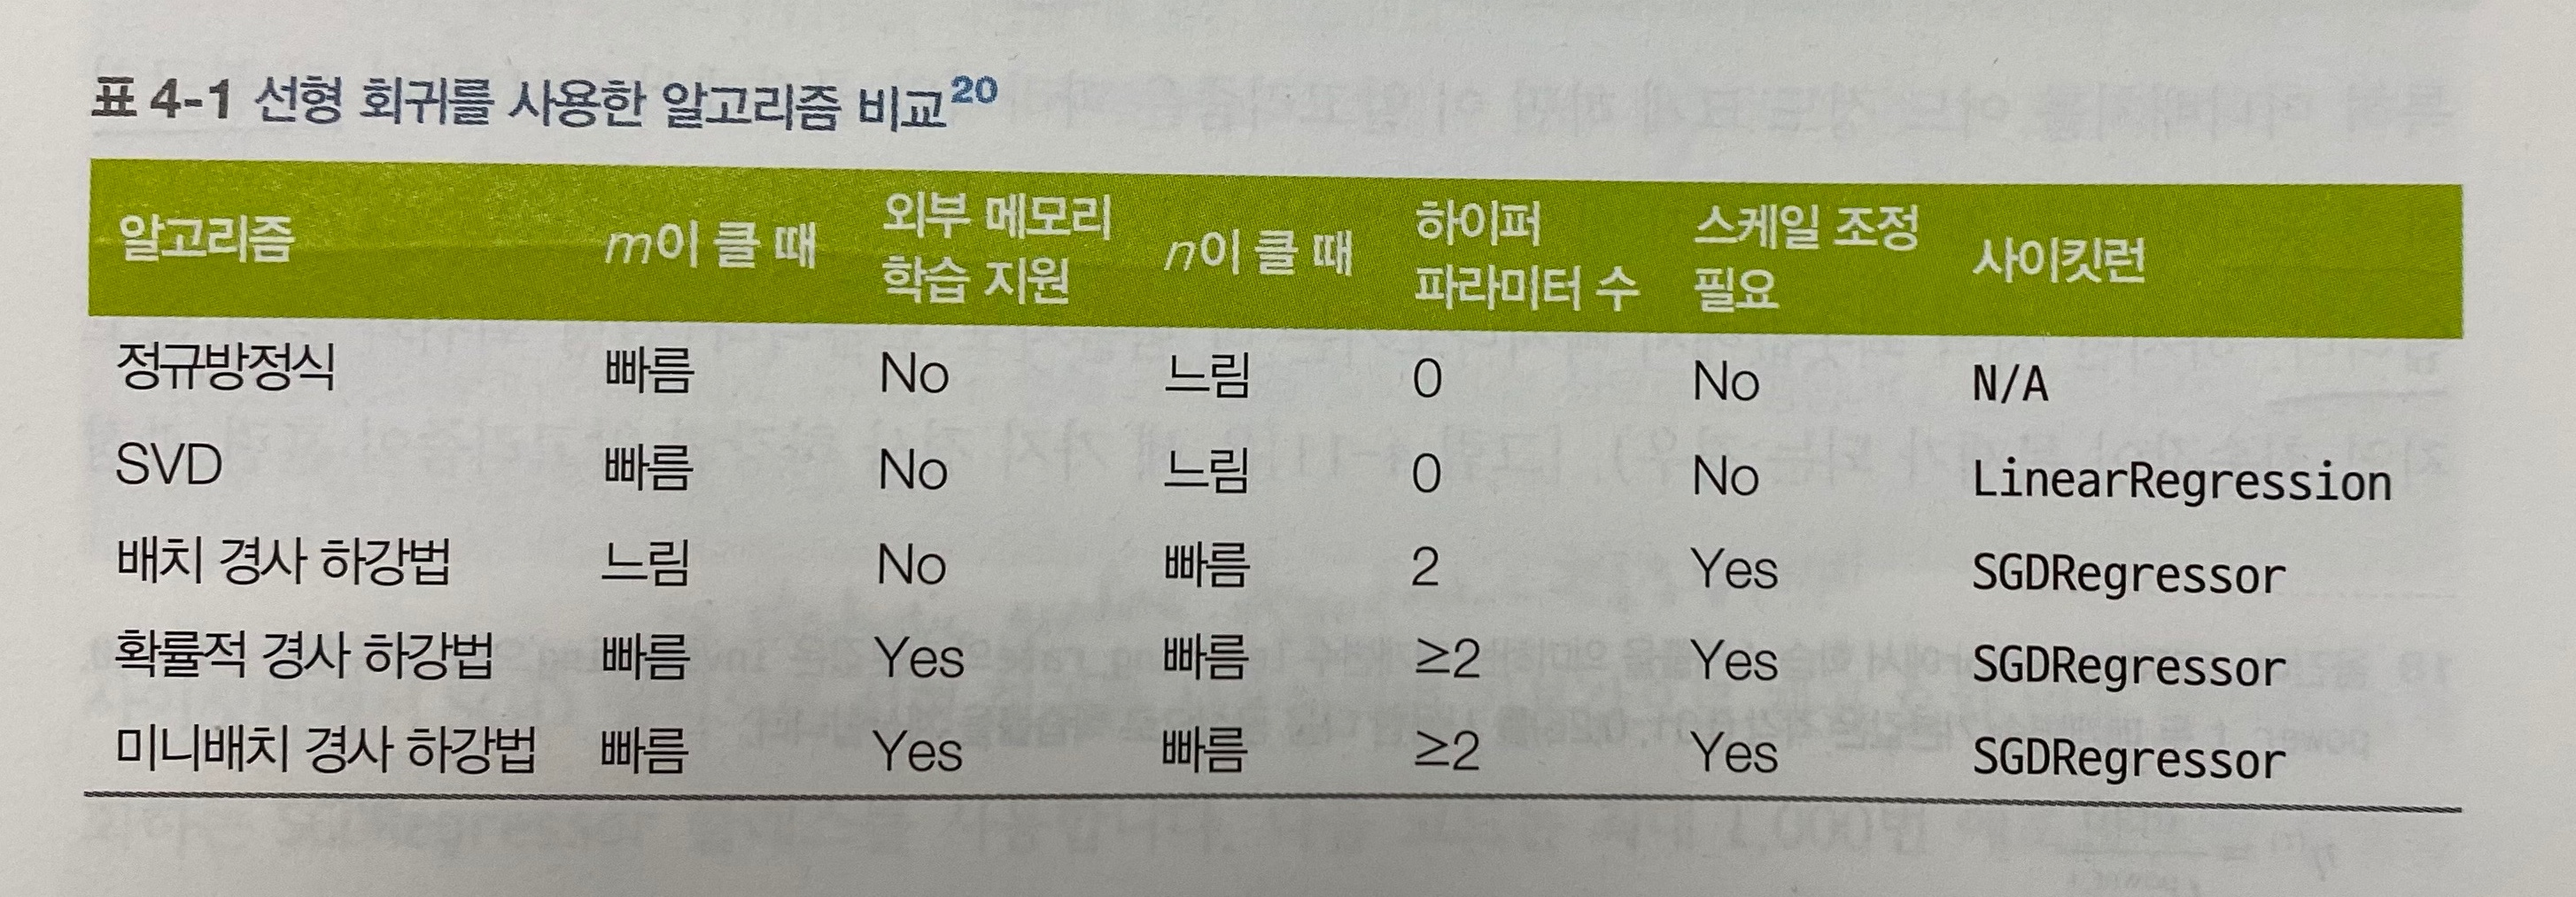

In [15]:
from IPython.display import Image
Image("/Users/minjun9282/ml/Chapter4/IMG_8074.JPG")